In [1]:
import numpy as np
from Utils.discrete_family import discrete_family
from Utils.barrier_affine import solve_barrier_tree, solve_barrier_tree_nonneg, solve_barrier_tree_box_PGD, solve_barrier_tree_nonneg_PGD
#from CART import RegressionTree
from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal as mvn
from Utils.plotting import  *
from Utils.simulation_helpers import *
from time import time
import cvxpy as cp

In [163]:
import numpy as np
from Utils.discrete_family import discrete_family
from Utils.barrier_affine import solve_barrier_tree_nonneg, solve_barrier_tree_box_PGD
from scipy.interpolate import interp1d
import cvxpy as cp
from scipy.stats import multivariate_normal

class TreeNode:
    def __init__(self, feature_index=None, threshold=None, pos=None,
                 left=None, right=None, value=None, prev_branch=None,
                 prev_node=None, membership=None, depth=0,
                 randomization=None, sd_rand=1., terminal=None):
        self.feature_index = feature_index  # Index of the feature to split on
        self.threshold = threshold  # Threshold value to split on
        self.pos = pos  # Position (the ascending order) of the split value
        self.left = left  # Left child node
        self.right = right  # Right child node
        self.value = value  # Value for leaf nodes (mean of target values)
        self.prev_branch = prev_branch  # List of (j, s, e) depicting a previous branch
        self.prev_node = prev_node
        self.membership = membership
        self.depth = depth
        self.randomization = randomization
        self.sd_rand = sd_rand
        self.terminal = terminal

def normalize(x):
    return x/x.sum()
def get_width(init_width, ref_hat_layer, obs_tar, n_coarse=50):
    width = init_width * (np.abs(obs_tar) + 1)
    x = np.linspace(-width, width, n_coarse)

    normalized_layers = [normalize(np.exp(layer)) for layer in ref_hat_layer]
    left_idx = None
    right_idx = None
    # Forward pass
    for i in range(n_coarse):
        vals = [prob[i] for prob in normalized_layers]
        #print(vals)
        if min(vals) > 0:
            left_idx = i - 1
            break
    # Backward pass
    for j in range(1, n_coarse):
        vals = [prob[n_coarse - j] for prob in normalized_layers]
        #print(vals)
        if min(vals) > 0:
            right_idx = n_coarse - j + 1
            break

    if left_idx == -1:
        x_l = None
    else:
        x_l = x[left_idx]
    if right_idx == n_coarse:
        x_r = None
    else:
        x_r = x[right_idx]
    assert left_idx < right_idx
    return x_l, x_r
class RegressionTree:
    def __init__(self, min_samples_split=2, max_depth=float('inf'),
                 min_proportion=0.2, min_bucket=5):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
        self.min_proportion = min_proportion
        self.min_bucket = min_bucket
        self.terminal_nodes = []
        self.terminal_parents = []

    def fit(self, X, y, sd=1):
        # sd is std. dev. of randomization
        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.root = self._build_tree(X, y, sd=sd)
        # print("Fit sd:", sd)

    def _build_tree(self, X, y, depth=0, membership=None,
                    prev_branch=None, sd=1.):
        # print("Build tree sd:", sd)
        """
        A recursive private function to build the tree
        by repeatedly splitting
        :param X: the covariates of the previous sub-region
        :param y: the response of the previous sub-region
        :param depth: depth of the previous split
        :param sd: std. dev. of randomization
        :return: a node characterizing this split and fitted value
        """
        num_samples, num_features = X.shape
        if depth == 0:
            membership = np.ones((num_samples,))
        else:
            assert membership is not None

        if prev_branch is None:
            prev_branch = []
            # print("pbc:", prev_branch)

        if num_samples >= max(self.min_samples_split, 2) and depth < self.max_depth:
            best_split = self._get_best_split(X, y, num_features, sd_rand=sd)
            if "feature_index" not in best_split.keys():
                print(best_split)
                print(X)
            feature_idx = best_split["feature_index"]
            threshold = best_split["threshold"]
            pos = best_split["position"]
            left_mbsp = self.X[:, feature_idx] <= threshold
            right_mbsp = self.X[:, feature_idx] > threshold
            left_mbsp = left_mbsp * membership  # n x 1 logical vector
            right_mbsp = right_mbsp * membership  # n x 1 logical vector
            # if best_split["gain"] > 0:
            left_prev_branch = prev_branch.copy()
            left_prev_branch.append([feature_idx, pos, 0])
            right_prev_branch = prev_branch.copy()
            right_prev_branch.append([feature_idx, pos, 1])
            # print(left_prev_branch)
            # print(right_prev_branch)
            left_subtree \
                = self._build_tree(best_split["X_left"],
                                   best_split["y_left"],
                                   depth + 1,
                                   membership=left_mbsp,
                                   prev_branch=left_prev_branch,
                                   sd=sd)
            right_subtree \
                = self._build_tree(best_split["X_right"],
                                   best_split["y_right"],
                                   depth + 1,
                                   membership=right_mbsp,
                                   prev_branch=right_prev_branch,
                                   sd=sd)

            leaf_value = self._calculate_leaf_value(y)
            cur_node = TreeNode(value=leaf_value,
                                feature_index=best_split["feature_index"],
                                threshold=best_split["threshold"],
                                pos=pos,
                                left=left_subtree, right=right_subtree,
                                membership=membership, depth=depth,
                                randomization=best_split["randomization"],
                                prev_branch=prev_branch,
                                sd_rand=sd, terminal=False)
            # Add this parent node to subnodes
            left_subtree.prev_node = cur_node
            right_subtree.prev_node = cur_node
            if left_subtree.terminal and right_subtree.terminal:
                # print(cur_node.threshold)
                self.terminal_parents.append(cur_node)
            return cur_node
        leaf_value = self._calculate_leaf_value(y)
        cur_node = TreeNode(value=leaf_value, membership=membership,
                            sd_rand=sd, depth=depth, terminal=True)
        self.terminal_nodes.append(cur_node)
        return cur_node

    def _get_best_split(self, X, y, num_features, sd_rand=1):
        """
        Input (X, y) of a (potentially sub-)region, return information about
        the best split on this regions
        Assuming no ties in features
        :param X: the (sub-)region's covariates
        :param y: the (sub-)region's response
        :param num_features: dimension of X
        :return: a dictionary containing
                {split_feature_idx, (numerical) splitting_threshold,
                split_position, left_sub_region, right_sub_region,
                gain}
        """
        best_split = {}
        min_loss = float('inf')
        num_sample = X.shape[0]
        randomization = np.zeros((num_sample - 1, num_features))
        min_proportion = self.min_proportion
        # Override min_proportion if min_bucket is set
        if self.min_bucket is not None:
            start = self.min_bucket
            end = num_sample - self.min_bucket - 1
        else:
            start = int(np.floor(num_sample * min_proportion))
            end = num_sample - int(np.ceil(num_sample * min_proportion)) - 1
        # print(start, end)
        # print("Get best split sd:", sd_rand)

        for feature_index in range(num_features):
            feature_values = X[:, feature_index]
            feature_values_sorted = feature_values.copy()
            feature_values_sorted.sort()
            # for i in range(len(feature_values_sorted) - 1):
            for i in range(start, end):
                threshold = feature_values_sorted[i]
                X_left, y_left, X_right, y_right = self._split(X, y, feature_index, threshold)
                if len(X_left) > 0 and len(X_right) > 0:
                    # print("entered 1")
                    if sd_rand != 0:
                        omega = np.random.normal(scale=sd_rand)
                    else:
                        omega = 0
                    randomization[i, feature_index] = omega
                    loss = self._calculate_loss(y_left, y_right, omega)
                    if loss < min_loss:
                        # print("entered 2")
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["position"] = i
                        best_split["X_left"] = X_left
                        best_split["y_left"] = y_left
                        best_split["X_right"] = X_right
                        best_split["y_right"] = y_right
                        best_split["loss"] = loss
                        best_split["randomization"] = randomization
                        # best_split[""]
                        min_loss = loss
        return best_split

    def _split(self, X, y, feature_index, threshold):
        left_mask = X[:, feature_index] <= threshold
        right_mask = X[:, feature_index] > threshold
        return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

    def _calculate_information_gain(self, y, y_left, y_right):
        var_total = np.var(y) * len(y)
        var_left = np.var(y_left) * len(y_left)
        var_right = np.var(y_right) * len(y_right)
        return var_total - (var_left + var_right)

    def _calculate_loss(self, y_left, y_right, randomization):
        n1 = len(y_left)
        n2 = len(y_right)
        n = n1 + n2
        """loss = ((np.var(y_left) * n1 + np.var(y_right) * np.sqrt(n2)) / np.sqrt(n1 + n2)
                + randomization)"""
        loss = ((- n1 * np.mean(y_left) ** 2 - n2 * np.mean(y_right) ** 2) / np.sqrt(n)
                + randomization)
        # Actually need not divide by n1+n2...
        # print("loss:", loss - randomization)
        # print("randomization:", randomization)
        return loss

    #
    def _calculate_leaf_value(self, y):
        """
        :param y: the response of the previous sub-region
        :return: the mean of the region
        """
        return np.mean(y)

    def predict(self, X):
        """
        :param X: the test dataset
        :return: fitted values
        """
        return np.array([self._predict(sample, self.root) for sample in X])

    def _predict(self, sample, tree):
        """
        Recursively searching the tree for the surrounding region of `sample`
        :param sample: the input covariates
        :param tree: the trained tree
        :return: fitted y value of `sample`
        """
        if tree.terminal:
            return tree.value
        feature_value = sample[tree.feature_index]
        if feature_value <= tree.threshold:
            return self._predict(sample, tree.left)
        else:
            return self._predict(sample, tree.right)

    def _approx_log_reference(self, node, grid, nuisance,
                              norm_contrast, sd=1, sd_rand=1,
                              use_CVXPY=True):
        ## TODO: 0. grid is a grid for eta'Y / (sd * norm_contrast);
        ##          first reconstruct eta'Y and then reconstruct Q
        ## TODO: 1. reconstruct Q from the grid
        ## TODO: 2. Perform Laplace approximation for each grid,
        #           and for each node split
        ## TODO: 3. Add back the constant term omitted in Laplace Approximation
        ## TODO: 4. Return reference measure

        prev_branch = node.prev_branch.copy()
        current_depth = node.depth
        ref_hat = np.zeros_like(grid)
        ref_hat_by_layer = []

        ## TODO: Move the node according to branch when evaluating integrals
        node = self.root

        # norm = np.linalg.norm(contrast)
        depth = 0

        while depth <= current_depth:
            warm_start = False
            ref_hat_depth = []
            # Subsetting the covariates to this current node
            X = self.X[node.membership.astype(bool)]
            j_opt = node.feature_index  # j^*
            s_opt = node.pos  # s^*
            randomization = node.randomization
            S_total, J_total = randomization.shape

            # Sort feature values to get the threshold
            feature_values_sorted = np.zeros_like(X)
            for j in range(J_total):
                feature_values_sorted[:, j] = X[:, j].copy()
                feature_values_sorted[:, j].sort()

            for g_idx, g in enumerate(grid):
                y_grid = g * sd ** 2 * norm_contrast + nuisance
                # TODO: Account for depth here

                y_g = y_grid[node.membership.astype(bool)]
                y_node = self.y[node.membership.astype(bool)]
                y_left = y_grid[node.left.membership.astype(bool)]
                y_right = y_grid[node.right.membership.astype(bool)]
                y_left_obs = self.y[node.left.membership.astype(bool)]
                y_right_obs = self.y[node.right.membership.astype(bool)]
                optimal_loss = self._calculate_loss(y_left, y_right,
                                                    randomization=0)
                opt_loss_obs = self._calculate_loss(y_left_obs, y_right_obs,
                                                    randomization=0)
                implied_mean = []
                observed_opt = []

                # TODO: Add a layer to account for depth of the tree
                for j in range(J_total):
                    num_sample = X.shape[0]
                    min_proportion = self.min_proportion
                    # Override min_proportion if min_bucket is set
                    if self.min_bucket is not None:
                        start = self.min_bucket
                        end = num_sample - self.min_bucket - 1
                    else:
                        start = int(np.floor(num_sample * min_proportion))
                        end = num_sample - int(np.ceil(num_sample * min_proportion)) - 1

                    for s in range(start, end):
                        if not (j == j_opt and s == s_opt):
                            threshold = feature_values_sorted[s, j]
                            X_left, y_left, X_right, y_right \
                                = self._split(X, y_g, j, threshold)
                            implied_mean_s_j \
                                = optimal_loss - self._calculate_loss(y_left,
                                                                      y_right,
                                                                      randomization=0)
                            # The split of the actually observed Y
                            X_left_o, y_left_o, X_right_o, y_right_o \
                                = self._split(X, y_node, j, threshold)
                            # print(y_left_o.shape)
                            # print(y_right_o.shape)
                            observed_opt_s_j = (opt_loss_obs -
                                                self._calculate_loss(y_left_o,
                                                                     y_right_o,
                                                                     randomization=0)
                                                + (randomization[s_opt, j_opt] -
                                                   randomization[s, j]))
                            # print("s:", s, "j:", j, "sopt:", s_opt, "jopt:", j_opt)

                            # Record the implied mean
                            # and observed optimization variable
                            implied_mean.append(implied_mean_s_j)
                            observed_opt.append(observed_opt_s_j)

                # The implied mean is given by the optimal loss minus
                # the loss at each split
                implied_mean = np.array(implied_mean)
                observed_opt = np.array(observed_opt)
                # print(observed_opt)
                assert np.max(observed_opt) < 0

                # dimension of the optimization variable
                n_opt = len(implied_mean)
                prec = (np.eye(n_opt) - np.ones((n_opt, n_opt))
                        / ((n_opt + 1))) / (sd_rand ** 2)

                if use_CVXPY:
                    if np.max(implied_mean) > 0:
                        #print(f"depth {depth}, {g_idx} computed")
                        ### USE CVXPY
                        # Define the variable
                        o = cp.Variable(n_opt)
                        # print(len(cond_implied_mean))

                        # Objective function: (1/2) * (u - Q)' * A * (u - Q)
                        objective = cp.Minimize(cp.quad_form(o - implied_mean,
                                                                   prec))
                        # Constraints: con_linear' * u <= con_offset
                        constraints = [o <= 0]
                        # print(offset_val)
                        # Problem definition
                        prob = cp.Problem(objective, constraints)
                        # Solve the problem
                        if warm_start:
                            o.value = prev_o
                        prob.solve(warm_start=warm_start)
                        warm_start = True
                        prev_o = o.value
                        ref_hat[g_idx] += (-0.5 * prob.value)
                        ref_hat_depth.append(-0.5 * prob.value)
                    # print("Min. implied mean:", np.min(implied_mean))
                    else:
                        #print(f"depth {depth}, {g_idx} skipped")
                        ref_hat_depth.append(0)

                else:
                    #       where we actually pass in g = eta'Y.
                    # print("Implied mean", implied_mean)
                    # print("feasible point", observed_opt)
                    # print("prec", prec)
                    # Approximate the selection probability
                    if np.max(implied_mean) > 0:
                        if warm_start:
                            init_point = prev_opt
                        else:
                            init_point = None
                        sel_prob, opt_point, _ = (
                            solve_barrier_tree_nonneg_PGD(implied_mean=implied_mean,
                                                          noise_sd=sd_rand,
                                                          init_point=init_point))
                        warm_start = True
                        prev_opt = opt_point
                        ref_hat[g_idx] += (sel_prob)
                        #ref_hat[g_idx] += (- sel_prob - const_term)
                        #print(f"Full at {g_idx}: {(sel_prob)}")
                        ref_hat_depth.append(sel_prob)
                    else:
                        ref_hat_depth.append(0)

            ref_hat_by_layer.append(ref_hat_depth)

            # Move to the next layer
            if depth < current_depth:
                dir = prev_branch[depth][2]
                if dir == 0:
                    node = node.left  # Depend on where the branch demands
                else:
                    node = node.right
                depth += 1
            else:
                depth += 1  # Exit the loop if targeting depth achieved

        ref_hat -= np.max(ref_hat)

        return np.array(ref_hat), ref_hat_by_layer

    def _condl_approx_log_reference(self, node, grid, nuisance,
                                    norm_contrast, sd=1, sd_rand=1,
                                    reduced_dim=5, use_CVXPY=True):
        ## TODO: 0. grid is a grid for eta'Y / (sd * ||contrast||_2);
        ##          first reconstruct eta'Y and then reconstruct Q
        ## TODO: 1. reconstruct Q from the grid
        ## TODO: 2. Perform Laplace approximation for each grid,
        #           and for each node split
        ## TODO: 3. Add back the constant term omitted in Laplace Approximation
        ## TODO: 4. Return reference measure

        r_is_none = reduced_dim is None

        def get_cond_dist(mean, cov, cond_idx, rem_idx, rem_val,
                          sd_rand, rem_dim):
            k = len(cond_idx)
            n_opt = len(mean)
            cond_mean = (mean[cond_idx] + 
                         (rem_val - mean[rem_idx]).sum() * np.ones(k) / (rem_dim + 1))
            cond_cov = (np.eye(k) + np.ones((k, k)) / (rem_dim + 1)) * (sd_rand**2)
            cond_prec = (np.eye(k) - np.ones((k, k)) / (n_opt + 1)) / (sd_rand**2)
            return cond_mean, cond_cov, cond_prec

        def get_log_pdf(observed_opt, implied_mean, rem_idx, sd_rand, rem_dim):
            x = observed_opt[rem_idx]
            mean = implied_mean[rem_idx]

            return (-0.5 * (np.linalg.norm(x - mean) ** 2 - np.sum(x - mean) ** 2 / (rem_dim + 1)) / sd_rand ** 2
                    )

        prev_branch = node.prev_branch.copy()
        current_depth = node.depth
        ref_hat = np.zeros_like(grid)
        marginal = np.zeros_like(grid)
        ref_hat_by_layer = []

        node = self.root

        # norm = np.linalg.norm(contrast)
        depth = 0

        while depth <= current_depth:
            #print(f"Depth {depth}")
            warm_start = False
            ref_hat_depth = []
            # Subsetting the covariates to this current node
            X = self.X[node.membership.astype(bool)]
            j_opt = node.feature_index  # j^*
            s_opt = node.pos  # s^*
            randomization = node.randomization
            S_total, J_total = randomization.shape

            # Sort feature values to get the threshold
            feature_values_sorted = np.zeros_like(X)
            for j in range(J_total):
                feature_values_sorted[:, j] = X[:, j].copy()
                feature_values_sorted[:, j].sort()

            for g_idx, g in enumerate(grid):
                # norm_contrast: eta / (||eta|| * sigma)
                # grid is a grid for eta'y / (||eta|| * sigma)
                y_grid = g * sd ** 2 * norm_contrast + nuisance

                # Reconstructing y
                y_g = y_grid[node.membership.astype(bool)]
                y_node = self.y[node.membership.astype(bool)]
                y_left = y_grid[node.left.membership.astype(bool)]
                y_right = y_grid[node.right.membership.astype(bool)]
                y_left_obs = self.y[node.left.membership.astype(bool)]
                y_right_obs = self.y[node.right.membership.astype(bool)]
                optimal_loss = self._calculate_loss(y_left, y_right,
                                                    randomization=0)
                opt_loss_obs = self._calculate_loss(y_left_obs, y_right_obs,
                                                    randomization=0)

                implied_mean = []
                observed_opt = []

                # Iterate over all covariates
                for j in range(J_total):
                    num_sample = X.shape[0]
                    min_proportion = self.min_proportion
                    # Override min_proportion if min_bucket is set
                    if self.min_bucket is not None:
                        start = self.min_bucket
                        end = num_sample - self.min_bucket - 1
                    else:
                        start = int(np.floor(num_sample * min_proportion))
                        end = num_sample - int(np.ceil(num_sample * min_proportion)) - 1

                    # for s in range(S_total - 1):
                    for s in range(start, end):
                        if not (j == j_opt and s == s_opt):
                            threshold = feature_values_sorted[s, j]
                            X_left, y_left, X_right, y_right \
                                = self._split(X, y_g, j, threshold)
                            implied_mean_s_j \
                                = optimal_loss - self._calculate_loss(y_left,
                                                                      y_right,
                                                                      randomization=0)
                            # The split of the actually observed Y
                            X_left_o, y_left_o, X_right_o, y_right_o \
                                = self._split(X, y_node, j, threshold)
                            # print(y_left_o.shape)
                            # print(y_right_o.shape)
                            observed_opt_s_j = (opt_loss_obs -
                                                self._calculate_loss(y_left_o,
                                                                     y_right_o,
                                                                     randomization=0)
                                                + (randomization[s_opt, j_opt] -
                                                   randomization[s, j]))
                            # print("s:", s, "j:", j, "sopt:", s_opt, "jopt:", j_opt)

                            # Record the implied mean
                            # and observed optimization variable
                            implied_mean.append(implied_mean_s_j)
                            observed_opt.append(observed_opt_s_j)

                # The implied mean is given by the optimal loss minus
                # the loss at each split
                implied_mean = np.array(implied_mean)
                observed_opt = np.array(observed_opt)
                if np.max(observed_opt) >= 0:
                    print(observed_opt)
                assert np.max(observed_opt) < 0

                if r_is_none:
                    reduced_dim = int(len(implied_mean) * 0.25)  # min(int(len(implied_mean) * 0.05), 10)
                    # print("reduced_dim:", reduced_dim)

                # Get the order of optimization variables in descending order
                t0 = time()
                obs_opt_order = np.argsort(observed_opt)[::-1]
                # reduced_dim = max(int(0.1*len(implied_mean)), 5)
                top_d_idx = obs_opt_order[0:reduced_dim]
                rem_d_idx = obs_opt_order[reduced_dim:]
                offset_val = observed_opt[obs_opt_order[reduced_dim]]
                #print("LB:", offset_val)
                #print("order:", obs_opt_order[:10])

                linear = np.zeros((reduced_dim * 2, reduced_dim))
                linear[0:reduced_dim, 0:reduced_dim] = np.eye(reduced_dim)
                linear[reduced_dim:, 0:reduced_dim] = -np.eye(reduced_dim)
                offset = np.zeros(reduced_dim * 2)
                offset[reduced_dim:] = -offset_val
                # dimension of the optimization variable
                n_opt = len(implied_mean)
                t1 = time()
                #print(f"Sorting takes {t1-t0}s")
                implied_cov = (np.ones((n_opt, n_opt)) + np.eye(n_opt)) * (sd_rand ** 2)
                cond_implied_mean, cond_implied_cov, cond_implied_prec = (
                    get_cond_dist(mean=implied_mean,
                                  cov=implied_cov,
                                  cond_idx=top_d_idx,
                                  rem_idx=rem_d_idx,
                                  rem_val=observed_opt[rem_d_idx],
                                  sd_rand=sd_rand,
                                  rem_dim=n_opt - reduced_dim))
                t2 = time()
                #print(f"Get conditional density {t2-t1}s")
                #print("implied mean:", cond_implied_mean[:10])
                
                if use_CVXPY:
                    if np.max(cond_implied_mean) > 0 or np.min(cond_implied_mean) < offset_val:
                        ### USE CVXPY
                        # Define the variable
                        o = cp.Variable(reduced_dim)
                        # print(n_opt)
                        # print(len(cond_implied_mean))

                        # Objective function: (1/2) * (u - Q)' * A * (u - Q)
                        objective = cp.Minimize(cp.quad_form(o - cond_implied_mean,
                                                                   cond_implied_prec))
                        # Constraints: con_linear' * u <= con_offset
                        constraints = [o >= offset_val, o <= 0]
                        # print(offset_val)
                        # Problem definition
                        prob = cp.Problem(objective, constraints)
                        # Solve the problem
                        prob.solve()
                        ref_hat[g_idx] += (-0.5 * prob.value)
                        ref_hat_depth.append(-0.5 * prob.value)
                    else:
                        ref_hat_depth.append(0)
                        
                    # Add omitted term
                    log_marginal = (get_log_pdf(observed_opt=observed_opt,
                                                implied_mean=implied_mean,
                                                rem_idx=rem_d_idx,
                                                sd_rand=sd_rand,
                                                rem_dim=n_opt - reduced_dim))
                    ref_hat[g_idx] += 0#log_marginal
                    ref_hat_depth[-1] += 0#(log_marginal)
                    marginal[g_idx] += log_marginal
                else:
                    if np.max(cond_implied_mean) > 0 or np.min(cond_implied_mean) < offset_val:
                        """sel_prob, _, _ = (
                            solve_barrier_tree_box_PGD(
                                Q=cond_implied_mean,
                                precision=cond_implied_prec,
                                lb=offset_val,
                                feasible_point=None))
                        const_term = (cond_implied_mean).T.dot(cond_implied_prec).dot(cond_implied_mean) / 2
                        ref_hat[g_idx] += (- sel_prob - const_term)
                        ref_hat_depth.append(sel_prob+const_term)"""
                        if warm_start:
                            init_point = prev_opt
                        else:
                            init_point = None
                        sel_prob, opt_point, _ = (
                            solve_barrier_tree_box_PGD(implied_mean=cond_implied_mean,
                                                       j = n_opt - reduced_dim,
                                                       lb=offset_val,
                                                       noise_sd=sd_rand,
                                                       init_point=init_point))
                        warm_start = True
                        prev_opt = opt_point
                        ref_hat[g_idx] += (sel_prob)
                        ref_hat_depth.append(sel_prob)
                    else:
                        ref_hat_depth.append(0)
                    # Add omitted term                    # Add omitted term
                    log_marginal = (get_log_pdf(observed_opt=observed_opt,
                                                implied_mean=implied_mean,
                                                rem_idx=rem_d_idx,
                                                sd_rand=sd_rand,
                                                rem_dim=n_opt - reduced_dim))
                    ref_hat[g_idx] += 0#log_marginal
                    ref_hat_depth[-1] += 0#(log_marginal)
                    marginal[g_idx] += log_marginal
                
                t3 = time()
                #print(f"Laplace takes {t3 - t2}s")
            
            ref_hat_by_layer.append(ref_hat_depth)

            # Move to the next layer
            if depth < current_depth:
                dir = prev_branch[depth][2]
                if dir == 0:
                    node = node.left  # Depend on where the branch demands
                else:
                    node = node.right
                depth += 1
            else:
                depth += 1  # Exit the loop if targeting depth achieved

        ref_hat -= np.max(ref_hat)

        return np.array(ref_hat), ref_hat_by_layer, marginal

    def split_inference(self, node, ngrid=1000, ncoarse=20, grid_width=15,
                        sd=1, level=0.9):
        """
        Inference for a split of a node
        :param node: the node whose split is of interest
        :return: p-values for difference in mean
        """
        # First determine the projection direction
        left_membership = node.left.membership
        right_membership = node.right.membership
        contrast = left_membership / np.sum(left_membership) - right_membership / np.sum(right_membership)
        sd_rand = node.sd_rand

        norm_contrast = contrast / (np.linalg.norm(contrast) * sd)

        # Using the normalized contrast in practice
        # for scale-free grid approximation
        observed_target = norm_contrast @ self.y
        # The nuisance parameter is defined the same way
        # as on papers
        nuisance = (self.y - np.linalg.outer(contrast, contrast)
                    @ self.y / (np.linalg.norm(contrast) ** 2))

        stat_grid = np.linspace(-grid_width, grid_width,
                                num=ngrid)

        if ncoarse is not None:
            coarse_grid = np.linspace(-grid_width, grid_width, ncoarse)
            eval_grid = coarse_grid
        else:
            eval_grid = stat_grid

        # Evaluate reference measure (selection prob.) over stat_grid
        ref = self._approx_log_reference(node=node,
                                         grid=eval_grid,
                                         nuisance=nuisance,
                                         contrast=contrast,
                                         norm_contrast=norm_contrast, sd=1,
                                         sd_rand=sd_rand)

        if ncoarse is None:
            logWeights = np.zeros((ngrid,))
            for g in range(ngrid):
                # Evaluate the log pdf as a sum of (log) gaussian pdf
                # and (log) reference measure
                # TODO: Check if the original exp. fam. density is correct
                logWeights[g] = (- 0.5 * (stat_grid[g]) ** 2 + ref[g])
            # normalize logWeights
            logWeights = logWeights - np.max(logWeights)
            condl_density = discrete_family(eval_grid,
                                            np.exp(logWeights),
                                            logweights=logWeights)
        else:
            # print("Coarse grid")
            approx_fn = interp1d(eval_grid,
                                 ref,
                                 kind='quadratic',
                                 bounds_error=False,
                                 fill_value='extrapolate')
            grid = np.linspace(-grid_width, grid_width, num=ngrid)
            sel_probs = np.zeros((ngrid,))
            logWeights = np.zeros((ngrid,))
            for g in range(ngrid):
                # TODO: Check if the original exp. fam. density is correct
                logWeights[g] = (- 0.5 * (grid[g]) ** 2 + approx_fn(grid[g]))
                sel_probs[g] = approx_fn(grid[g])

            # normalize logWeights
            logWeights = logWeights - np.max(logWeights)

            condl_density = discrete_family(grid, np.exp(logWeights),
                                            logweights=logWeights)

        if np.isnan(logWeights).sum() != 0:
            print("logWeights contains nan")
        elif (logWeights == np.inf).sum() != 0:
            print("logWeights contains inf")
        elif (np.asarray(ref) == np.inf).sum() != 0:
            print("ref contains inf")
        elif (np.asarray(ref) == -np.inf).sum() != 0:
            print("ref contains -inf")
        elif np.isnan(np.asarray(ref)).sum() != 0:
            print("ref contains nan")

        """interval = (condl_density.equal_tailed_interval
                        (observed=contrast.T @ self.y,
                         alpha=1-level))
        if np.isnan(interval[0]) or np.isnan(interval[1]):
            print("Failed to construct intervals: nan")"""

        # TODO: Fix this; pass in observed values
        pivot = condl_density.ccdf(x=observed_target
                                     / (np.linalg.norm(contrast) * sd),
                                   theta=0)

        return (pivot, condl_density, contrast, norm_contrast,
                observed_target, logWeights, sel_probs)

    def node_inference(self, node, ngrid=1000, ncoarse=20, grid_w_const=1.5,
                       sd=1, query_grid=True, use_cvxpy=False, query_size=30, 
                       interp_kind='linear'):
        """
        Inference for a split of a node
        :param node: the node whose split is of interest
        :return: p-values for difference in mean
        """
        # First determine the projection direction
        membership = node.membership
        contrast = membership / np.sum(membership)
        sd_rand = node.sd_rand
        # print("Inference sd", sd_rand)

        # Normalized contrast: The inner product norm_contrast'Y has sd = 1.
        norm_contrast = contrast / (np.linalg.norm(contrast) * sd)

        # Using the normalized contrast in practice
        # for scale-free grid approximation
        observed_target = norm_contrast @ self.y
        # The nuisance parameter is defined the same way
        # as on papers
        nuisance = (self.y - np.linalg.outer(contrast, contrast)
                    @ self.y / (np.linalg.norm(contrast) ** 2))

        ref_hat_computed = False
        if query_grid:
            grid_width_q = grid_w_const * (np.abs(observed_target) + 1)
            print(f"initial grid: {-grid_width_q}, {grid_width_q}")
            coarse_grid = np.linspace(-grid_width_q,
                                      grid_width_q, query_size)
            ref, ref_layer = self._approx_log_reference(node=node.prev_node,
                                                        grid=coarse_grid,
                                                        nuisance=nuisance,
                                                        norm_contrast=norm_contrast, sd=sd,
                                                        sd_rand=sd_rand,
                                                        use_CVXPY=use_cvxpy)

            x_l, x_r = get_width(grid_w_const, ref_layer, observed_target, n_coarse=query_size)

            if x_l is not None and x_r is not None:
                #width = max(np.abs(x_l), np.abs(x_r))
                #stat_grid = np.linspace(-width, width, num=ngrid)
                stat_grid = np.linspace(x_l, x_r, num=ngrid)
                if ncoarse is not None:
                    coarse_grid = np.linspace(x_l, x_r, ncoarse)
                    #coarse_grid = np.linspace(-width, width, num=ncoarse)
                    eval_grid = coarse_grid
                    print(f"queried grid: {x_l}, {x_r}")
                    #print(f"queried grid: {-width}, {width}")
                ref_hat_computed = False
            else:
                # Use query grid instead
                ncoarse = query_size
                stat_grid = np.linspace(-grid_width_q, grid_width_q, num=ngrid)
                eval_grid = coarse_grid
                ref_hat_computed = True
                print("x_l, x_r is None")

        else:
            # If not querying grid
            grid_width = grid_w_const * (np.abs(observed_target) + 1)

            stat_grid = np.linspace(-grid_width,
                                    grid_width, num=ngrid)

            if ncoarse is not None:
                coarse_grid = np.linspace(-grid_width,
                                          grid_width, ncoarse)
                eval_grid = coarse_grid
            else:
                eval_grid = stat_grid

        # If not using the query grid's reference measure,
        # then compute the reference measure using the queried grid
        if not ref_hat_computed:
            ref, ref_layer = self._approx_log_reference(node=node.prev_node,
                                             grid=eval_grid,
                                             nuisance=nuisance,
                                             norm_contrast=norm_contrast, sd=sd,
                                             sd_rand=sd_rand,
                                             use_CVXPY=use_cvxpy)

        if ncoarse is None:
            logWeights = np.zeros((ngrid,))
            for g in range(ngrid):
                # Evaluate the log pdf as a sum of (log) gaussian pdf
                # and (log) reference measure
                # TODO: Check if the original exp. fam. density is correct
                logWeights[g] = (- 0.5 * (stat_grid[g]) ** 2 + ref[g])
            # normalize logWeights
            logWeights = logWeights - np.max(logWeights)
            condl_density = discrete_family(eval_grid,
                                            np.exp(logWeights),
                                            logweights=logWeights)
        else:
            # print("Coarse grid")
            approx_fn = interp1d(eval_grid,
                                 ref,
                                 kind=interp_kind,
                                 bounds_error=False,
                                 fill_value='extrapolate')
            """grid = np.linspace(-grid_width,
                               grid_width, num=ngrid)"""
            grid = stat_grid
            logWeights = np.zeros((ngrid,))
            suff = np.zeros((ngrid,))
            sel_probs = np.zeros((ngrid,))
            for g in range(ngrid):
                logWeights[g] = (- 0.5 * (grid[g]) ** 2 + approx_fn(grid[g]))
                suff[g] = - 0.5 * (grid[g]) ** 2
                sel_probs[g] = approx_fn(grid[g])

            # normalize logWeights
            logWeights = logWeights - np.max(logWeights)

            # condl_density is a discrete approximation
            # to the exponential family distribution with
            # natural parameter theta := eta'mu / (||eta|| * sigma)
            # and
            # sufficient statistic X := eta'y / (||eta|| * sigma) = norm_contrast'Y
            condl_density = discrete_family(grid, np.exp(logWeights),
                                            logweights=logWeights)

        if np.isnan(logWeights).sum() != 0:
            print("logWeights contains nan")
        elif (logWeights == np.inf).sum() != 0:
            print("logWeights contains inf")
        elif (np.asarray(ref) == np.inf).sum() != 0:
            print("ref contains inf")
        elif (np.asarray(ref) == -np.inf).sum() != 0:
            print("ref contains -inf")
        elif np.isnan(np.asarray(ref)).sum() != 0:
            print("ref contains nan")

        """interval = (condl_density.equal_tailed_interval
                        (observed=contrast.T @ self.y,
                         alpha=1-level))
        if np.isnan(interval[0]) or np.isnan(interval[1]):
            print("Failed to construct intervals: nan")"""

        # TODO: Fix this; pass in observed values
        pivot = condl_density.ccdf(x=observed_target,
                                   theta=0)

        """# Recall: observed_target = norm_contrast @ self.y
        L, U = condl_density.equal_tailed_interval(observed=observed_target,
                                                   alpha=0.1)

        print('CI:', L, ',', U)"""

        return (pivot, condl_density, contrast, norm_contrast,
                observed_target, logWeights, suff, sel_probs, ref_layer)

    def condl_split_inference(self, node, ngrid=1000, ncoarse=20, grid_w_const=1.5,
                              sd=1, reduced_dim=5, use_cvxpy=False):
        """
        Inference for a split of a node
        :param node: the node whose split is of interest
        :return: p-values for difference in mean
        """
        # First determine the projection direction
        left_membership = node.left.membership
        right_membership = node.right.membership
        contrast = left_membership / np.sum(left_membership) - right_membership / np.sum(right_membership)
        sd_rand = node.sd_rand

        # Normalized contrast: The inner product norm_contrast'Y has sd = 1.
        norm_contrast = contrast / (np.linalg.norm(contrast) * sd)

        # Using the normalized contrast in practice
        # for scale-free grid approximation
        observed_target = norm_contrast @ self.y
        # The nuisance parameter is defined the same way
        # as on papers
        nuisance = (self.y - np.linalg.outer(contrast, contrast)
                    @ self.y / (np.linalg.norm(contrast) ** 2))

        grid_width = grid_w_const * (np.abs(observed_target) + 1)

        stat_grid = np.linspace(-grid_width, grid_width, num=ngrid)

        if ncoarse is not None:
            coarse_grid = np.linspace(-grid_width, grid_width, ncoarse)
            eval_grid = coarse_grid
        else:
            eval_grid = stat_grid

        ref = self._condl_approx_log_reference(node=node,
                                               grid=eval_grid,
                                               nuisance=nuisance,
                                               norm_contrast=norm_contrast, sd=sd,
                                               sd_rand=sd_rand,
                                               reduced_dim=reduced_dim,
                                               use_CVXPY=use_cvxpy)

        if ncoarse is None:
            logWeights = np.zeros((ngrid,))
            for g in range(ngrid):
                # Evaluate the log pdf as a sum of (log) gaussian pdf
                # and (log) reference measure
                # TODO: Check if the original exp. fam. density is correct
                logWeights[g] = (- 0.5 * (stat_grid[g]) ** 2 + ref[g])
            # normalize logWeights
            logWeights = logWeights - np.max(logWeights)
            condl_density = discrete_family(eval_grid,
                                            np.exp(logWeights),
                                            logweights=logWeights)
        else:
            # print("Coarse grid")
            approx_fn = interp1d(eval_grid,
                                 ref,
                                 kind='quadratic',
                                 bounds_error=False,
                                 fill_value='extrapolate')
            grid = np.linspace(-grid_width, grid_width, num=ngrid)
            logWeights = np.zeros((ngrid,))
            suff = np.zeros((ngrid,))
            sel_probs = np.zeros((ngrid,))
            for g in range(ngrid):
                # TODO: Check if the original exp. fam. density is correct

                logWeights[g] = (- 0.5 * (grid[g]) ** 2 + approx_fn(grid[g]))
                suff[g] = - 0.5 * (grid[g]) ** 2
                sel_probs[g] = approx_fn(grid[g])

            # normalize logWeights
            logWeights = logWeights - np.max(logWeights)

            # condl_density is a discrete approximation
            # to the exponential family distribution with
            # natural parameter theta := eta'mu / (||eta|| * sigma)
            # and
            # sufficient statistic X := eta'y / (||eta|| * sigma) = norm_contrast'Y
            condl_density = discrete_family(grid, np.exp(logWeights),
                                            logweights=logWeights)

        if np.isnan(logWeights).sum() != 0:
            print("logWeights contains nan")
        elif (logWeights == np.inf).sum() != 0:
            print("logWeights contains inf")
        elif (np.asarray(ref) == np.inf).sum() != 0:
            print("ref contains inf")
        elif (np.asarray(ref) == -np.inf).sum() != 0:
            print("ref contains -inf")
        elif np.isnan(np.asarray(ref)).sum() != 0:
            print("ref contains nan")

        """interval = (condl_density.equal_tailed_interval
                        (observed=contrast.T @ self.y,
                         alpha=1-level))
        if np.isnan(interval[0]) or np.isnan(interval[1]):
            print("Failed to construct intervals: nan")"""

        # TODO: Fix this; pass in observed values
        pivot = condl_density.ccdf(x=observed_target,
                                   theta=0)

        """# Recall: observed_target = norm_contrast @ self.y
        L, U = condl_density.equal_tailed_interval(observed=observed_target,
                                                   alpha=0.1)

        print('CI:', L, ',', U)"""

        return (pivot, condl_density, contrast, norm_contrast,
                observed_target, logWeights, suff, sel_probs)

    def condl_node_inference(self, node, ngrid=1000, ncoarse=20, grid_w_const=1.5,
                             sd=1, reduced_dim=5, use_cvxpy=False, interp_kind='linear',
                             query_grid=True, query_size=30):
        """
        Inference for a split of a node
        :param node: the node whose split is of interest
        :return: p-values for difference in mean
        """
        # First determine the projection direction
        membership = node.membership
        contrast = membership / np.sum(membership)
        sd_rand = node.sd_rand
        # print("Inference sd", sd_rand)

        # Normalized contrast: The inner product norm_contrast'Y has sd = 1.
        norm_contrast = contrast / (np.linalg.norm(contrast) * sd)

        # Using the normalized contrast in practice
        # for scale-free grid approximation
        observed_target = norm_contrast @ self.y
        # The nuisance parameter is defined the same way
        # as on papers
        nuisance = (self.y - np.linalg.outer(contrast, contrast)
                    @ self.y / (np.linalg.norm(contrast) ** 2))
        
        ref_hat_computed = False
        if query_grid:
            grid_width_q = grid_w_const * (np.abs(observed_target) + 1)
            print(f"initial grid: {-grid_width_q}, {grid_width_q}")
            coarse_grid = np.linspace(-grid_width_q,
                                      grid_width_q, query_size)
            ref, ref_layer, marg = (
                self._condl_approx_log_reference(node=node.prev_node,
                                                 grid=coarse_grid,
                                                 nuisance=nuisance,
                                                 norm_contrast=norm_contrast, 
                                                 sd=sd, sd_rand=sd_rand,
                                                 reduced_dim=reduced_dim,
                                                 use_CVXPY=use_cvxpy))

            x_l, x_r = get_width(grid_w_const, ref_layer, observed_target, n_coarse=query_size)
            
            if x_l is not None and x_r is not None:
                #width = max(np.abs(x_l), np.abs(x_r))
                #stat_grid = np.linspace(-width, width, num=ngrid)
                stat_grid = np.linspace(x_l, x_r, num=ngrid)
                if ncoarse is not None:
                    coarse_grid = np.linspace(x_l, x_r, ncoarse)
                    #coarse_grid = np.linspace(-width, width, num=ncoarse)
                    eval_grid = coarse_grid
                    print(f"queried grid: {x_l}, {x_r}")
                    #print(f"queried grid: {-width}, {width}")
                ref_hat_computed = False
            else:
                # Use query grid instead
                ncoarse = query_size
                stat_grid = np.linspace(-grid_width_q, grid_width_q, num=ngrid)
                eval_grid = coarse_grid
                ref_hat_computed = True
                print("x_l, x_r is None")

        else:
            # If not querying grid
            grid_width = grid_w_const * (np.abs(observed_target) + 1)

            stat_grid = np.linspace(-grid_width,
                                    grid_width, num=ngrid)

            if ncoarse is not None:
                coarse_grid = np.linspace(-grid_width,
                                          grid_width, ncoarse)
                eval_grid = coarse_grid
            else:
                eval_grid = stat_grid

        # If not using the query grid's reference measure,
        # then compute the reference measure using the queried grid
        if not ref_hat_computed:
            ref, ref_layer, marg = (
                self._condl_approx_log_reference(node=node.prev_node,
                                                 grid=eval_grid,
                                                 nuisance=nuisance,
                                                 norm_contrast=norm_contrast, 
                                                 sd=sd, sd_rand=sd_rand,
                                                 reduced_dim=reduced_dim,
                                                 use_CVXPY=use_cvxpy))

        if ncoarse is None:
            logWeights = np.zeros((ngrid,))
            suff = np.zeros((ngrid,))
            sel_probs = np.zeros((ngrid,))
            marginal = np.zeros((ngrid,))
            for g in range(ngrid):
                # Evaluate the log pdf as a sum of (log) gaussian pdf
                # and (log) reference measure
                # TODO: Check if the original exp. fam. density is correct
                logWeights[g] = (- 0.5 * (stat_grid[g]) ** 2 + ref[g])
                suff[g] = - 0.5 * (stat_grid[g]) ** 2
                sel_probs[g] = ref[g]
                marginal[g] = marg[g]
            # normalize logWeights
            logWeights = logWeights - np.max(logWeights)
            condl_density = discrete_family(eval_grid,
                                            np.exp(logWeights),
                                            logweights=logWeights)
        else:
            # print("Coarse grid")
            approx_fn = interp1d(eval_grid,
                                 ref,
                                 kind='quadratic',
                                 bounds_error=False,
                                 fill_value='extrapolate')
            approx_fn_marg = interp1d(eval_grid,
                                      marg,
                                      kind='quadratic',
                                      bounds_error=False,
                                      fill_value='extrapolate')
            grid = stat_grid
            logWeights = np.zeros((ngrid,))
            suff = np.zeros((ngrid,))
            sel_probs = np.zeros((ngrid,))
            marginal = np.zeros((ngrid,))
            for g in range(ngrid):
                # TODO: Check if the original exp. fam. density is correct

                logWeights[g] = (- 0.5 * (grid[g]) ** 2 + approx_fn(grid[g]))
                suff[g] = - 0.5 * (grid[g]) ** 2
                sel_probs[g] = approx_fn(grid[g])
                marginal[g] = approx_fn_marg(grid[g])

            # normalize logWeights
            logWeights = logWeights - np.max(logWeights)

            # condl_density is a discrete approximation
            # to the exponential family distribution with
            # natural parameter theta := eta'mu / (||eta|| * sigma)
            # and
            # sufficient statistic X := eta'y / (||eta|| * sigma) = norm_contrast'Y
            condl_density = discrete_family(grid, np.exp(logWeights),
                                            logweights=logWeights)

        if np.isnan(logWeights).sum() != 0:
            print("logWeights contains nan")
        elif (logWeights == np.inf).sum() != 0:
            print("logWeights contains inf")
        elif (np.asarray(ref) == np.inf).sum() != 0:
            print("ref contains inf")
        elif (np.asarray(ref) == -np.inf).sum() != 0:
            print("ref contains -inf")
        elif np.isnan(np.asarray(ref)).sum() != 0:
            print("ref contains nan")

        """interval = (condl_density.equal_tailed_interval
                        (observed=contrast.T @ self.y,
                         alpha=1-level))
        if np.isnan(interval[0]) or np.isnan(interval[1]):
            print("Failed to construct intervals: nan")"""

        # TODO: Fix this; pass in observed values
        pivot = condl_density.ccdf(x=observed_target,
                                   theta=0)

        """# Recall: observed_target = norm_contrast @ self.y
        L, U = condl_density.equal_tailed_interval(observed=observed_target,
                                                   alpha=0.1)

        print('CI:', L, ',', U)"""

        return (pivot, condl_density, contrast, norm_contrast,
                observed_target, logWeights, suff, sel_probs, ref_layer, marginal)

    def _delete_children(self, node):
        """
        :param node: The node whose children are to be deleted
        :return:
        """
        node.left = None
        node.right = None
        # Keep track of the terminal nodes
        node.terminal = True

    def bottom_up_pruning(self, level=0.1, sd_y=1):
        temp_term_parents = []
        while self.terminal_parents:
            parent = self.terminal_parents.pop()
            pivot, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs = (
                self.condl_split_inference(node=parent,
                                           ngrid=10000,
                                           ncoarse=200,
                                           grid_w_const=10,
                                           reduced_dim=1,
                                           sd=sd_y,
                                           use_cvxpy=True))

            # Prune if the split is insignificant
            if min(pivot, 1 - pivot) >= level / 2:
                self._delete_children(parent)
                if parent.prev_branch:
                    if parent.prev_branch[-1][2] == 0:
                        neighbor = parent.prev_node.right
                    else:
                        neighbor = parent.prev_node.left
                    # If this parent node's parent is now a terminal parent node
                    # add it to the terminal parents list
                    if neighbor.terminal:
                        self.terminal_parents.append(parent.prev_node)
            else:
                # If the split is significant,
                # preserve it in the temp list
                temp_term_parents.append(parent)

        self.terminal_parents = temp_term_parents

    def print_branches(self, node=None, start=True, depth=0):
        """
        Recursively printing (with proper indentation denoting depth) the tree
        :param node: the node to be printed
        :param start: a logic flag for whether the node is the root
        :param depth: depth of a node to be printed
        """
        if start:
            node = self.root
        if node is None:
            return
        if node.left or node.right:
            print("\t" * depth, "j:", node.feature_index)
            print("\t" * depth, "threshold:", node.threshold)
            if node.left and node.right:
                print("\t" * depth, "left:")
                self.print_branches(node.left, start=False, depth=depth + 1)
                print("\t" * depth, "right:")
                self.print_branches(node.right, start=False, depth=depth + 1)
            elif node.right:
                print("\t" * depth, "left:")
                self.print_branches(node.right, start=False, depth=depth + 1)
            else:
                print("\t" * depth, "right:")
                self.print_branches(node.left, start=False, depth=depth + 1)
        return

## Testing Approximate Reference

In [164]:
n = 200
p = 5

# Sanity check: seed 10023, node 1: (200, 15) Y, (50, 15) N, (50, 5) Y, (100, 15) Y
np.random.seed(10028)
X = np.random.normal(size=(n, p))
a = 1
b = 2

mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
sd = 2
noise_sd = 1
y = mu + np.random.normal(size=(n,), scale=sd)
# Create and train the regression tree
reg_tree = RegressionTree(max_depth=3, min_proportion=0,
                          min_samples_split=50, min_bucket=20,)

In [165]:
reg_tree.fit(X, y, sd = noise_sd * sd)

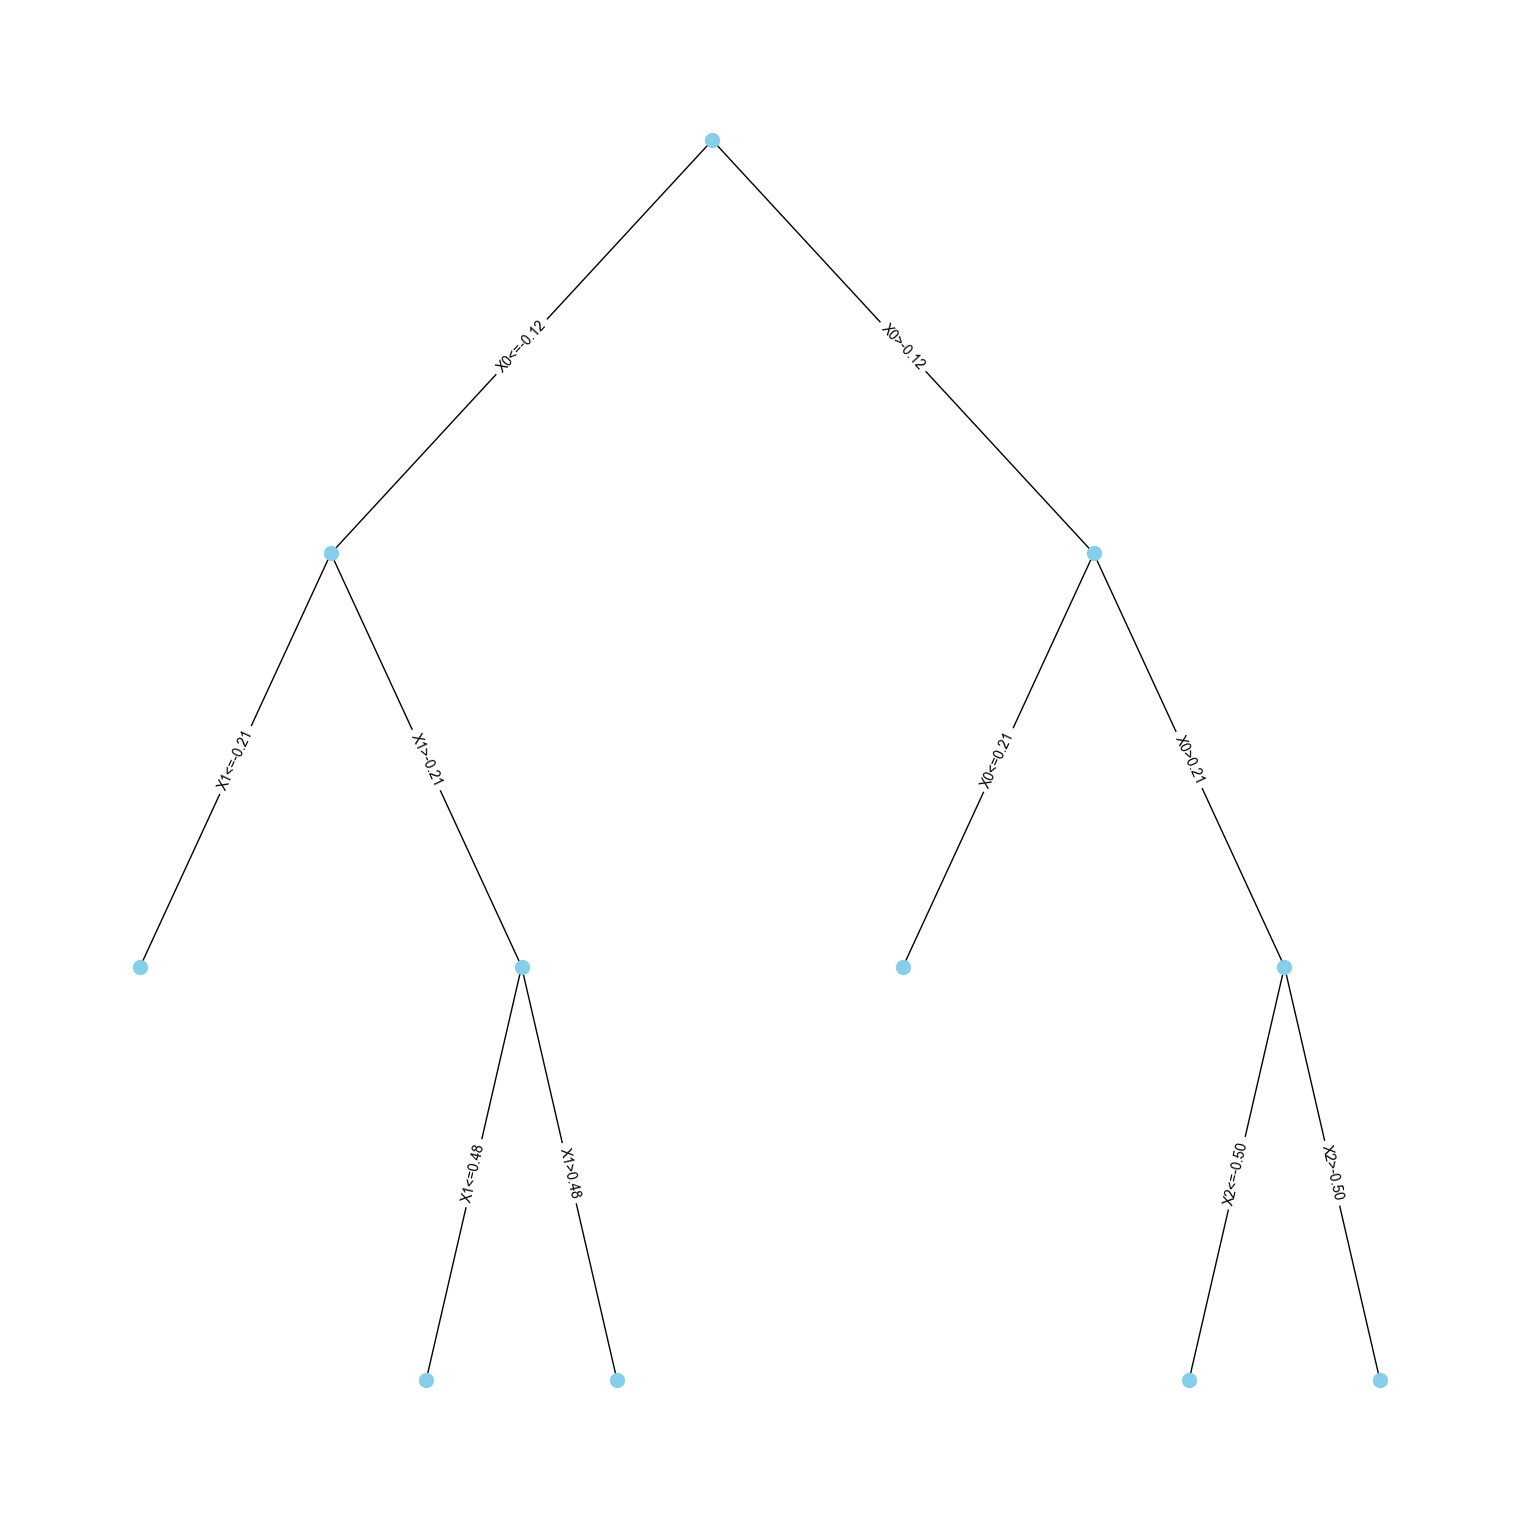

In [166]:
draw_tree(reg_tree.root)

In [167]:
t1 = time()
(pval, dist, contrast, norm_contrast, obs_tar, logW, suff, 
 sel_probs, ref_hat_layer, marginal) = (
    reg_tree.condl_node_inference(node=reg_tree.terminal_nodes[1], 
                                  ngrid=10000,
                                  ncoarse=50,
                                  grid_w_const=5,
                                  query_grid=False,
                                  query_size=200,
                                  reduced_dim=1,
                                  sd=sd, use_cvxpy=False))
t2 = time()
print(t2 - t1)
print(dist.equal_tailed_interval(observed=norm_contrast.dot(y),
                                      alpha=0.1))
print(norm_contrast.dot(mu))

1.630011796951294
(np.float64(7.00232192440977), np.float64(12.701185572850896))
12.23247045094871


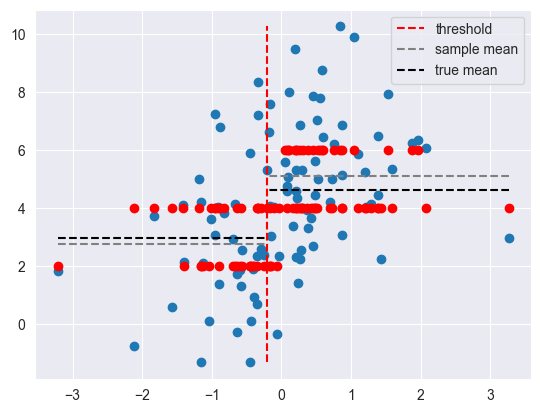

In [168]:
print_split_info(reg_tree.root.left, X, y, mu)

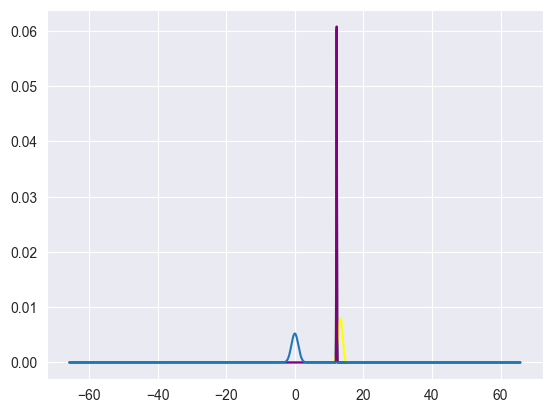

In [173]:
import matplotlib.pyplot as plt


def normalize(x):
    return x / x.sum()

width = 5 * (np.abs(obs_tar) + 1)
x = np.linspace(-width, width, 50) 
z = np.linspace(-width, width, 10000)  
#plt.plot(z, normalize(np.exp(sel_probs - marginal - np.max(sel_probs - marginal))), color="red")
plt.plot(z, normalize(np.exp(marginal)), color="green")
plt.plot(z, normalize(np.exp(sel_probs)), color="yellow")
plt.plot(z, normalize(np.exp(marginal + sel_probs)), color="purple")
#plt.plot(z, normalize(np.exp(ref_hat_layer[0])), color="blue", linestyle='None', marker='o')
#plt.plot(z, normalize(np.exp(ref_hat_layer[1])), color="red", linestyle='None', marker='o')
#plt.plot(x, normalize(np.exp(ref_hat_layer[2])), color="green",
#         linestyle='None', marker='o')
#plt.plot(z, normalize(np.exp(sel_probs)), color="yellow")
plt.plot(z, normalize(np.exp(suff)))
#plt.plot(x, normalize(dist.pdf(theta=norm_contrast.dot(mu))), color="blue")
#plt.plot(x, normalize(dist_full.pdf(theta=norm_contrast.dot(mu))), color="blue")
#plt.ylim(-5000, 1000)

In [76]:
print(dist.equal_tailed_interval(observed=norm_contrast.dot(y),
                                      alpha=0.1))
print(norm_contrast.dot(mu))

(np.float64(-11.881487724420591), np.float64(4.334026495949599))
9.041944301794654


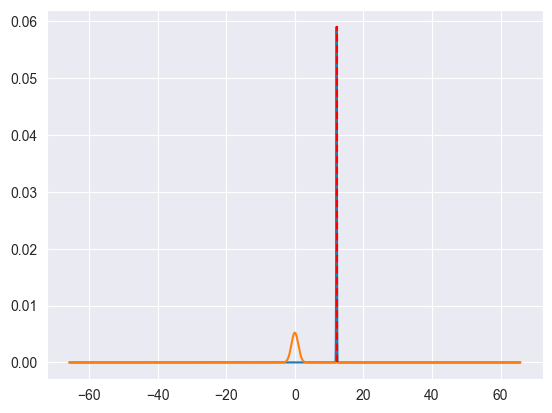

In [143]:
plt.plot(z, dist.pdf(theta=10))
plt.plot(z, normalize(np.exp(suff)))
plt.vlines(obs_tar, ymin=0, 
           ymax=np.max(dist.pdf(theta=norm_contrast.dot(mu))),
           linestyles='--', colors='grey')
plt.vlines(norm_contrast.dot(mu), ymin=0,
           ymax=np.max(dist.pdf(theta=norm_contrast.dot(mu))),
           linestyles='--', colors='red')

In [23]:
dist.ccdf(theta=norm_contrast.dot(mu), x=obs_tar)

np.float64(0.9953362461601652)

In [319]:
def root_inference_sim(n = 50, p = 5, a = 0.1, b = 0.1, 
                       sd_y = 1, noise_sd = 1, start=0, end=100):
    pivots = []
    naive_pivots = []
    coverage = []
    naive_coverage = []
    length = []
    naive_length = []
    level=0.1
    for i in range(start, end):
        print(i, "th simulation")
        np.random.seed(i+1000)
        X = np.random.normal(size=(n, p))

        mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
        y = mu + np.random.normal(size=(n,), scale=sd_y)
        # Create and train the regression tree
        reg_tree = RegressionTree(min_samples_split=50, max_depth=3,
                                  min_bucket=20, min_proportion=0.)
        reg_tree.fit(X, y, sd = noise_sd * sd_y)
        
        #if not reg_tree.root.left.left:
        #    continue
        """pval, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs\
            = (reg_tree.condl_split_inference(node=reg_tree.root, ngrid=10000,
                                              ncoarse=100, grid_width=15,
                                              reduced_dim=1, sd=sd_y,
                                              use_cvxpy=True))"""
        
        """pval, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs, marginal \
            = (reg_tree.condl_node_inference(node=reg_tree.terminal_nodes[1],
                                             ngrid=10000,
                                             ncoarse=200,
                                             grid_w_const=5,
                                             reduced_dim=None,
                                             sd=sd_y,
                                             use_cvxpy=False))"""
        pval, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs, _ \
            = (reg_tree.node_inference(node=reg_tree.terminal_nodes[0],
                                       ngrid=10000,
                                       ncoarse=200,
                                       grid_w_const=30,
                                       sd=sd_y,
                                       use_cvxpy=False,
                                       query_grid=True,
                                       query_size=50,
                                       interp_kind='linear'))
        
        """x = np.linspace(-5 * np.abs(obs_tar), 5 * np.abs(obs_tar), 10000)
        plt.plot(x, normalize(np.exp(sel_probs)), color="yellow")"""
        
        target = norm_contrast.dot(mu)
        pivot_i = dist.ccdf(theta=target, x=obs_tar)
        pivots.append(pivot_i)
        
        naive_pivot = Z_test(y=y, norm_contrast=norm_contrast, 
                             null=target)
        naive_pivots.append(naive_pivot)
        
        # Naive after tree value
        # Confidence intervals
        naive_CI = [contrast.dot(y) -
                    np.linalg.norm(contrast) * sd_y * ndist.ppf(1 - level / 2),
                    contrast.dot(y) +
                    np.linalg.norm(contrast) * sd_y * ndist.ppf(1 - level / 2)]
        naive_coverage.append((contrast.dot(mu) >= naive_CI[0] and contrast.dot(mu) <= naive_CI[1]))
        
        selective_CI = (dist.equal_tailed_interval(observed=norm_contrast.dot(y),
                                                   alpha=level))
        selective_CI = np.array(selective_CI)
        selective_CI *= np.linalg.norm(contrast) * sd_y
        coverage.append((contrast.dot(mu) >= selective_CI[0] and contrast.dot(mu) <= selective_CI[1]))
        length.append(selective_CI[1] - selective_CI[0])
        naive_length.append(naive_CI[1] - naive_CI[0])
        if not coverage[-1]:
            print(f"depth {reg_tree.terminal_nodes[0].depth}, {i}th iter not covered")
        
    
    return pivots, naive_pivots, coverage, naive_coverage, length, naive_length

In [418]:
t1 = time()
pivots_50, naive_pivots_50, coverage, naive_coverage, length, naive_length \
    = root_inference_sim(start=142, end=200, n=200,
                         sd_y=2, noise_sd=1, 
                         a=1,b=2)
t2 = time()

# 100, 105, 108, 121, 122, 125, 127, 131, 140, 
# 143, 145, 148, 156, 159, 173, 190, 

142 th simulation
initial grid: -352.7725144241215, 352.7725144241215
queried grid: -266.3792455855612, 266.3792455855612
143 th simulation
initial grid: -222.21263198520947, 222.21263198520947
queried grid: -122.44369517552357, 122.44369517552357
depth 2, 143th iter not covered
144 th simulation
initial grid: -277.651167402838, 277.651167402838
queried grid: -277.651167402838, 277.651167402838
145 th simulation
initial grid: -125.39455388677143, 125.39455388677143
queried grid: -110.04011871696267, 110.04011871696267
depth 3, 145th iter not covered
146 th simulation
initial grid: -346.4095731658163, 346.4095731658163
x_l, x_r is None
147 th simulation
initial grid: -137.8684244136867, 137.8684244136867
queried grid: -36.57733708934546, 36.57733708934546
148 th simulation
initial grid: -248.7072941089454, 248.7072941089454
queried grid: -55.83224969792656, 55.83224969792656
depth 3, 148th iter not covered
149 th simulation
initial grid: -305.73560530680936, 305.73560530680936
x_l, x_r 

(array([ 5.,  9.,  3.,  5.,  6., 11., 12., 17., 13., 19.]),
 array([3.22759360e-04, 1.00276720e-01, 2.00230681e-01, 3.00184642e-01,
        4.00138602e-01, 5.00092563e-01, 6.00046524e-01, 7.00000484e-01,
        7.99954445e-01, 8.99908406e-01, 9.99862367e-01]),
 <BarContainer object of 10 artists>)

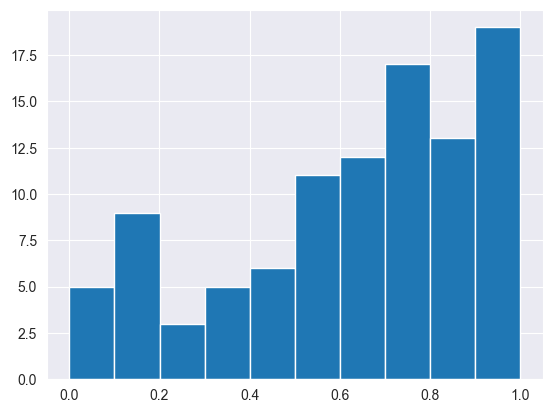

In [221]:
plt.hist(pivots_50, bins=10)

(array([ 4.,  7.,  5.,  5.,  5., 12., 16., 17.,  9., 20.]),
 array([4.16044352e-04, 1.00362166e-01, 2.00308287e-01, 3.00254409e-01,
        4.00200530e-01, 5.00146651e-01, 6.00092773e-01, 7.00038894e-01,
        7.99985016e-01, 8.99931137e-01, 9.99877258e-01]),
 <BarContainer object of 10 artists>)

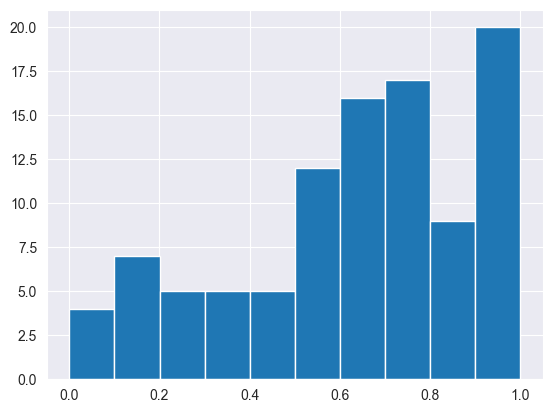

In [222]:
plt.hist(naive_pivots_50, bins=10)

In [244]:
def plot_ecdf(data):
    # Step 2: Sort the data
    data_sorted = np.sort(data)

    # Step 3: Calculate the empirical CDF
    # For each point, the CDF value is the proportion of data points less than or equal to that point
    cdf_values = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

    # Step 4: Plot the empirical CDF
    plt.figure(figsize=(6, 6))
    plt.step(data_sorted, cdf_values, where='post', label='Empirical CDF')
    plt.title('Empirical Cumulative Distribution Function')
    # Add a y=x line
    plt.plot(data_sorted, data_sorted, label='Uniform CDF', linestyle='--')
    plt.xlabel('Data Points')
    plt.ylabel('CDF')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_ecdfs(data_list, labels, title=None):
    # Step 2: Sort the data
    sorted_data = []
    for data in data_list:
        data_sorted = np.sort(data)
        sorted_data.append(data_sorted)

    # Step 3: Calculate the empirical CDF
    # For each point, the CDF value is the proportion of data points less than or equal to that point
    cdf_values = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

    # Step 4: Plot the empirical CDF
    plt.figure(figsize=(6, 6))
    for i, data in enumerate(sorted_data):
        plt.step(data, cdf_values, where='post', 
                 label=labels[i])
    if not title:
        plt.title('Empirical Cumulative Distribution Function')
    else:
        plt.title(title)
    # Add a y=x line
    plt.plot(data_sorted, data_sorted, label='Uniform CDF', linestyle='--')
    plt.xlabel('Data Points')
    plt.ylabel('CDF')
    plt.grid(True)
    plt.legend()
    plt.show()


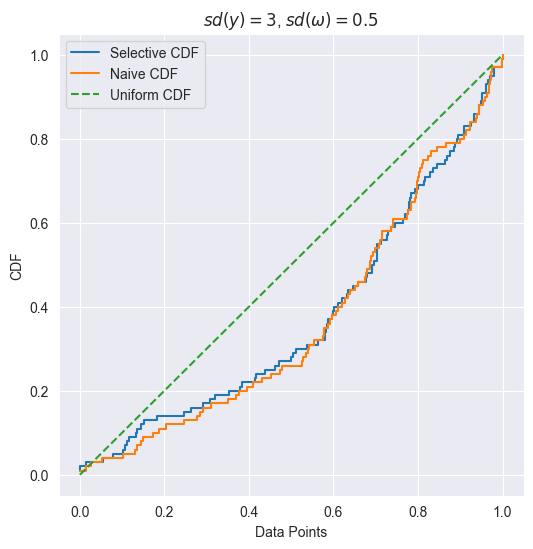

In [245]:
plot_ecdfs([pivots_50, naive_pivots_50], ["Selective CDF", "Naive CDF"],
           title="$sd(y)=3$, $sd(\omega) = 0.5$")

In [246]:
np.mean(coverage)

np.float64(0.86)

In [247]:
np.mean(naive_coverage)

np.float64(0.85)

In [248]:
# 100, 105, 108, 121, 122, 125, 127, 131, 140,  

In [398]:
n = 200
p = 5

# Sanity check: seed 10023, node 1: (200, 15) Y, (50, 15) N, (50, 5) Y, (100, 15) Y
np.random.seed(1140)
X = np.random.normal(size=(n, p))
a = 1
b = 2

mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
sd = 2
noise_sd = 1
y = mu + np.random.normal(size=(n,), scale=sd)
# Create and train the regression tree
reg_tree = RegressionTree(max_depth=3, min_proportion=0,
                          min_samples_split=50, min_bucket=20,)

In [399]:
reg_tree.fit(X, y, sd = noise_sd * sd)

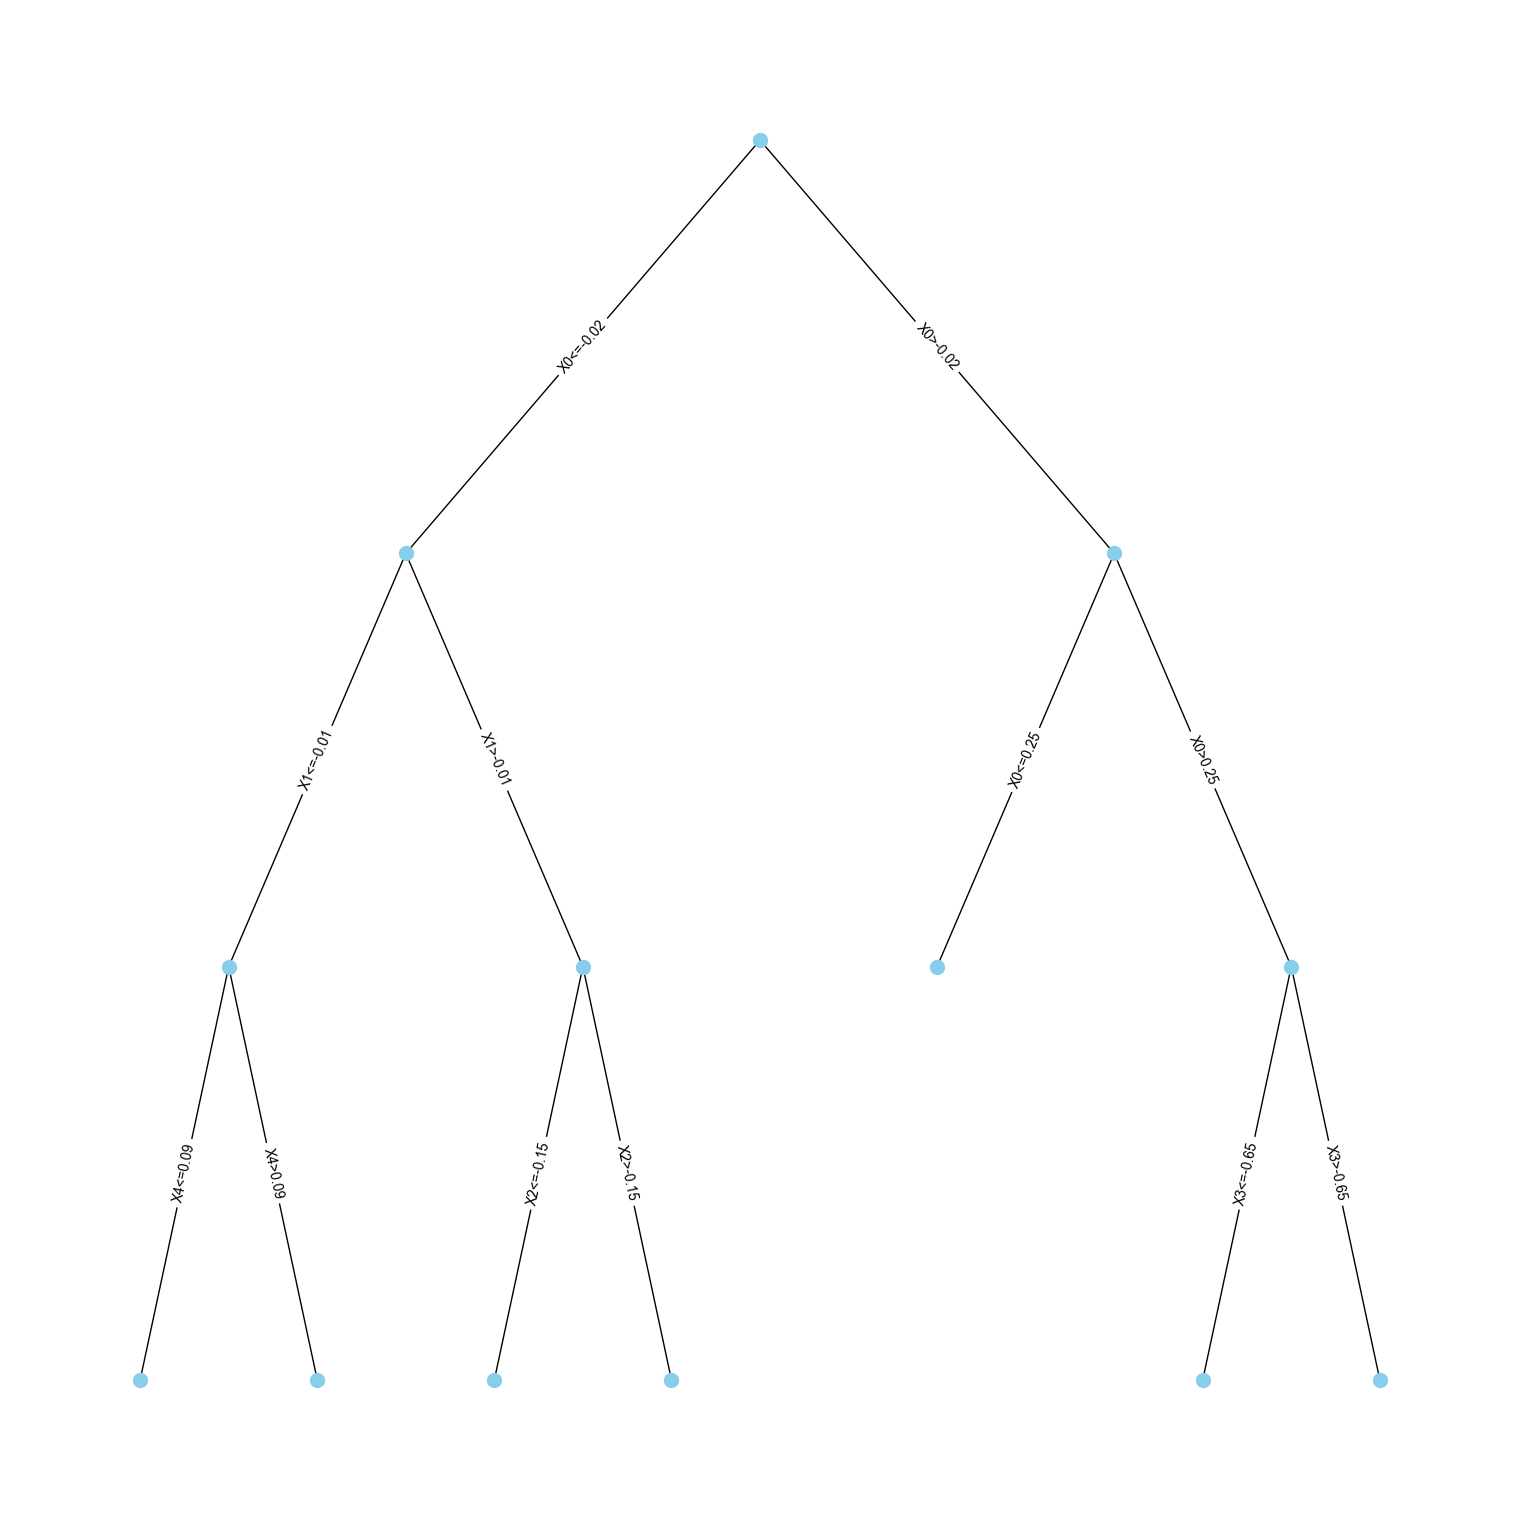

In [400]:
draw_tree(reg_tree.root)

In [416]:
t1 = time()
pval_full, dist_full, contrast_full, norm_contrast_full, obs_tar_full, logW_full, suff_full, sel_probs_full, ref_hat_layer = (
    reg_tree.node_inference(node=reg_tree.terminal_nodes[0], 
                            ngrid=10000,
                            ncoarse=200,
                            grid_w_const=30,
                            query_grid=True,
                            query_size=200,
                            sd=sd, use_cvxpy=False, interp_kind='linear'))
t2 = time()
print(t2 - t1)
print(dist_full.equal_tailed_interval(observed=norm_contrast_full.dot(y),
                                      alpha=0.1))
print(norm_contrast_full.dot(mu))

initial grid: -1623.4396838222, 1623.4396838222
x_l, x_r is None
Numerically unstable
10.954385042190552
(np.float64(3.0006052754338493), np.float64(6.277408768933569))
6.9402209378856705


In [391]:
t1 = time()
pval_full, dist_full, contrast_full, norm_contrast_full, obs_tar_full, logW_full, suff_full, sel_probs_full, ref_hat_layer = (
    reg_tree.node_inference(node=reg_tree.terminal_nodes[0], 
                            ngrid=10000,
                            ncoarse=50,
                            grid_w_const=15,
                            query_grid=False,
                            query_size=50,
                            sd=sd, use_cvxpy=False, interp_kind='quadratic'))
t2 = time()
print(t2 - t1)
#(np.float64(4.7504543362024485), np.float64(7.897169643645196))
print(dist_full.equal_tailed_interval(observed=norm_contrast_full.dot(y),
                                      alpha=0.1))
print(norm_contrast_full.dot(mu))

3.980086088180542
(np.float64(1.7372652273468714), np.float64(5.033208382807377))
5.3999999999999995


In [27]:
import matplotlib.pyplot as plt
def normalize(x):
    return x/x.sum()

width = 15 * (np.abs(obs_tar_full) + 1)
g = np.linspace(-width, width, 200)
z = np.linspace(-width, width, 10000)
#plt.plot(x, normalize(np.exp(sel_probs - marginal - np.max(sel_probs - marginal))), color="red")
#plt.plot(x, (marginal), color="blue")
#plt.plot(x, normalize(np.exp(sel_probs)), color="green")
plt.plot(g, normalize(np.exp(ref_hat_layer[0])), color="blue", 
         linestyle='None', marker='o')
plt.plot(g, normalize(np.exp(ref_hat_layer[1])), color="red", 
         linestyle='None', marker='o')
plt.plot(g, normalize(np.exp(ref_hat_layer[2])), color="green", 
         linestyle='None', marker='o')
plt.plot(z, normalize(np.exp(sel_probs_full)), color="yellow")
#plt.plot(x, normalize(dist.pdf(theta=norm_contrast.dot(mu))), color="blue")
#plt.plot(x, normalize(dist_full.pdf(theta=norm_contrast.dot(mu))), color="blue")
#plt.ylim(-5000, 1000)

NameError: name 'obs_tar_full' is not defined

In [404]:
obs_tar_full

np.float64(4.411465612740667)

In [405]:
normalize(np.exp(sel_probs_full))

array([0.        , 0.        , 0.        , ..., 0.00037093, 0.00037093,
       0.00037093])

In [18]:
plt.plot(z, dist_full.pdf(theta=norm_contrast_full.dot(mu)))
plt.vlines(obs_tar_full, ymin=0, 
           ymax=np.max(dist_full.pdf(theta=norm_contrast_full.dot(mu))),
           linestyles='--', colors='grey')
plt.vlines(norm_contrast_full.dot(mu), ymin=0,
           ymax=np.max(dist_full.pdf(theta=norm_contrast_full.dot(mu))),
           linestyles='--', colors='red')

NameError: name 'dist_full' is not defined

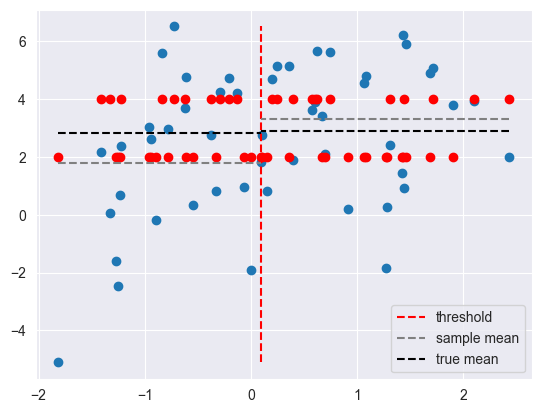

In [407]:
print_split_info(reg_tree.root.left.left, X, y, mu)

In [304]:
reg_tree.terminal_nodes[0].membership.sum()

np.float64(22.0)

In [67]:
size = [node.membership.sum() for node in reg_tree.terminal_nodes]

In [68]:
size

[np.float64(20.0),
 np.float64(27.0),
 np.float64(17.0),
 np.float64(27.0),
 np.float64(25.0),
 np.float64(57.0),
 np.float64(27.0)]